# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [78]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

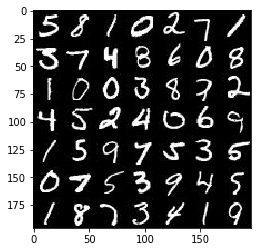

In [79]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

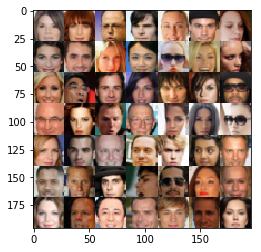

In [80]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [82]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return inputs_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [83]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.1
        keep_prob = 0.9
        
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.nn.dropout(x1, keep_prob)

        x2 = tf.layers.conv2d(x1, 128, 3, strides=1, padding='same',activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2,x2)
        x2 = tf.nn.dropout(x2, keep_prob)


        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same',activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.nn.dropout(x3, keep_prob)


        flat = tf.reshape(x3, [-1, 7*7*256])
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [84]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        keep_prob = 0.9
        
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 64, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2*alpha, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)

        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [85]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [86]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):

        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [87]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [88]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2 - 1 
                _ = sess.run(disc_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z:batch_z,  lr:learning_rate})
                if steps % 20 == 0:
                    train_loss_d = disc_loss.eval({input_real:batch_images, input_z: batch_z})
                    train_loss_g = gen_loss.eval({input_z:batch_z}) 
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 1.1811
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 1.4327
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.8987
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 2.2278


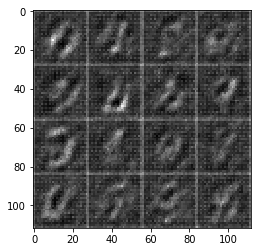

Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 2.8056
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 3.9910
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 3.7472
Epoch 1/2... Discriminator Loss: 0.3824... Generator Loss: 4.3324
Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 3.3652


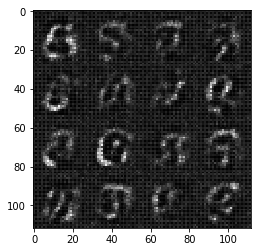

Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 4.8743
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 5.1169
Epoch 1/2... Discriminator Loss: 0.3587... Generator Loss: 5.1053
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 4.7470
Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 2.9060


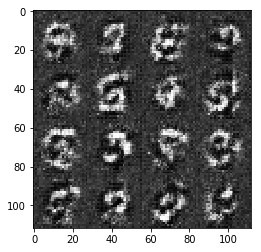

Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 5.4720
Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 3.1544
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 2.5398
Epoch 1/2... Discriminator Loss: 0.4961... Generator Loss: 2.8547
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 4.0840


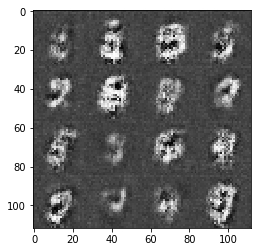

Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 2.9591
Epoch 1/2... Discriminator Loss: 0.5041... Generator Loss: 2.6234
Epoch 1/2... Discriminator Loss: 0.4433... Generator Loss: 2.9553
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 2.1004


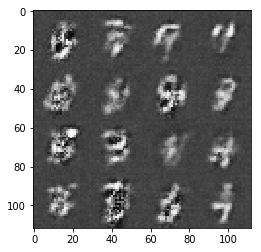

Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 1.2818
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 2.7988
Epoch 1/2... Discriminator Loss: 0.4511... Generator Loss: 3.1179
Epoch 1/2... Discriminator Loss: 0.4516... Generator Loss: 4.1405
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 2.7660


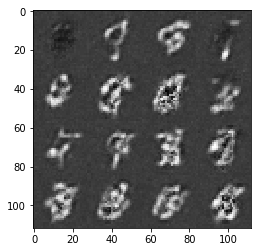

Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 3.4237
Epoch 1/2... Discriminator Loss: 0.4319... Generator Loss: 3.6132
Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 3.4050
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 3.8669
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 3.0413


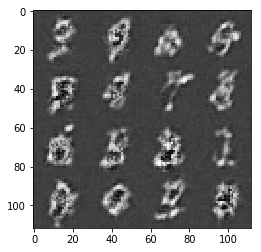

Epoch 1/2... Discriminator Loss: 0.4105... Generator Loss: 3.7973
Epoch 1/2... Discriminator Loss: 0.4113... Generator Loss: 3.8981
Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 4.2409
Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 2.5096
Epoch 1/2... Discriminator Loss: 0.5193... Generator Loss: 3.6165


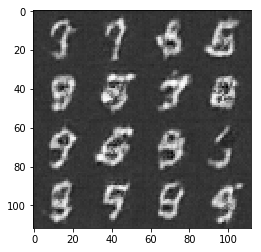

Epoch 1/2... Discriminator Loss: 0.4346... Generator Loss: 3.6210
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 2.9984
Epoch 1/2... Discriminator Loss: 0.4299... Generator Loss: 3.0958
Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 2.9882
Epoch 1/2... Discriminator Loss: 0.4605... Generator Loss: 4.6937


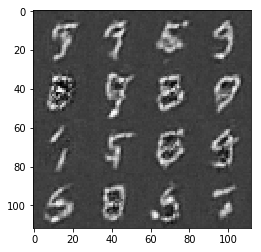

Epoch 1/2... Discriminator Loss: 0.4347... Generator Loss: 3.3096
Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 3.0886
Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 3.8524
Epoch 2/2... Discriminator Loss: 0.4449... Generator Loss: 3.7354
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 3.2575


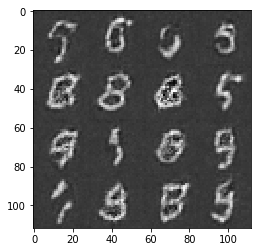

Epoch 2/2... Discriminator Loss: 0.4182... Generator Loss: 4.0224
Epoch 2/2... Discriminator Loss: 0.5139... Generator Loss: 2.4153
Epoch 2/2... Discriminator Loss: 0.6373... Generator Loss: 1.9979
Epoch 2/2... Discriminator Loss: 0.3970... Generator Loss: 3.6714
Epoch 2/2... Discriminator Loss: 0.4618... Generator Loss: 4.8499


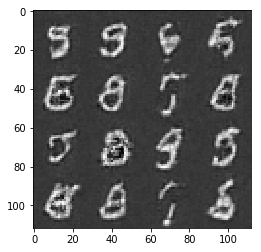

Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 4.5318
Epoch 2/2... Discriminator Loss: 0.4015... Generator Loss: 4.4097
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 3.9003
Epoch 2/2... Discriminator Loss: 5.3461... Generator Loss: 0.0276
Epoch 2/2... Discriminator Loss: 0.6085... Generator Loss: 2.3353


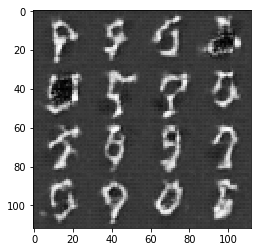

Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 2.8144
Epoch 2/2... Discriminator Loss: 0.4768... Generator Loss: 3.1494
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 3.5448
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 2.4417
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 2.4936


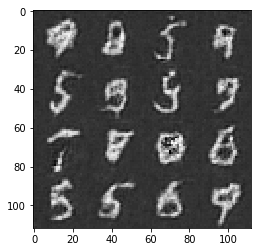

Epoch 2/2... Discriminator Loss: 0.4282... Generator Loss: 3.4865
Epoch 2/2... Discriminator Loss: 0.4261... Generator Loss: 3.7198
Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 3.5426
Epoch 2/2... Discriminator Loss: 0.4180... Generator Loss: 3.8775
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 3.4025


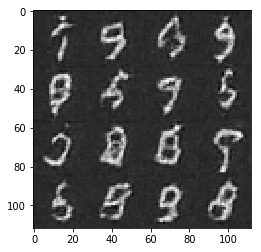

Epoch 2/2... Discriminator Loss: 0.4326... Generator Loss: 2.9557
Epoch 2/2... Discriminator Loss: 0.6264... Generator Loss: 2.1835
Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 3.0069
Epoch 2/2... Discriminator Loss: 0.4021... Generator Loss: 3.9113
Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 3.4076


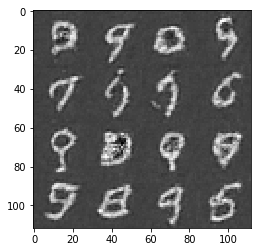

Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 3.1935
Epoch 2/2... Discriminator Loss: 0.4378... Generator Loss: 3.6491
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 2.1168
Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 4.5862
Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 3.0340


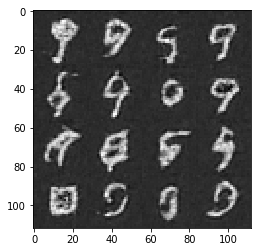

Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 4.2240
Epoch 2/2... Discriminator Loss: 0.3987... Generator Loss: 4.1401
Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 4.7836
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 3.5825
Epoch 2/2... Discriminator Loss: 0.4803... Generator Loss: 2.5986


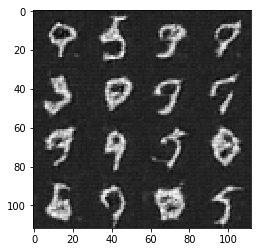

Epoch 2/2... Discriminator Loss: 0.4590... Generator Loss: 2.4307
Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 2.4026
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 4.3455
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 2.7362
Epoch 2/2... Discriminator Loss: 0.4458... Generator Loss: 2.9057


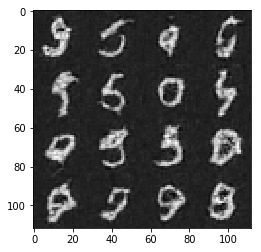

Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 3.8338
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 4.4814
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 3.7043


In [89]:
tf.reset_default_graph()

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 2.0786
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.9603
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 2.0739


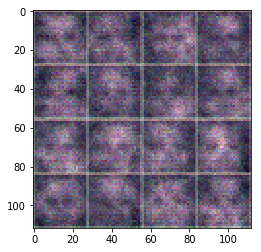

Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 2.7450
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 2.4885
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.9608
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.7161
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 2.7013


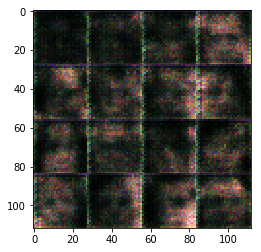

Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 3.4788
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 3.8991
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 4.1824
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 4.2464
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 4.5343


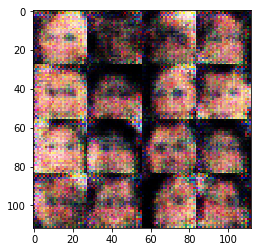

Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 4.8651
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 4.8536
Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 4.3089
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 5.5359
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 4.8400


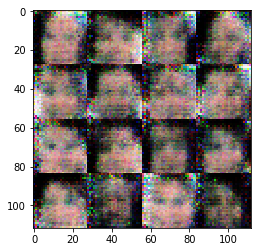

Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 3.2270
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 4.5530
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 4.9427
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 4.9212
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 4.7019


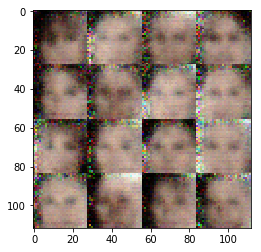

Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 3.7652
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 4.4214
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 4.5932
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 5.2551
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 3.4190


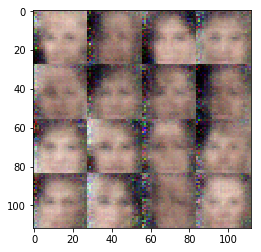

Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 5.3030
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 3.8012
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 3.5133
Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 3.5626
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 3.7494


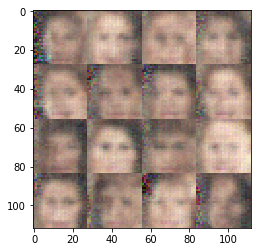

Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 3.2358
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 3.3525
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 3.2074
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 2.8139
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 2.0878


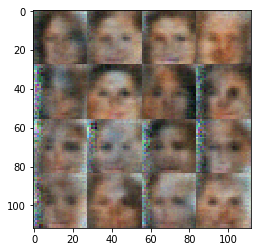

Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 3.4357
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 2.4460
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 2.6534
Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 2.7326
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 3.1634


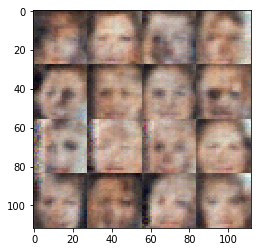

Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 2.8303
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 2.4498
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.5935
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 2.6478
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.4628


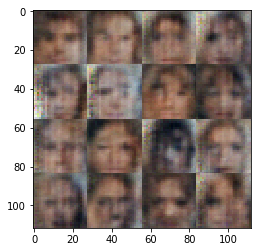

Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 3.1753
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.5371
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 2.1834
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 2.3180
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 2.7051


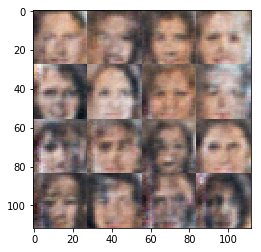

Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 2.2460
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.9525
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 2.2627
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 2.0335
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 2.5872


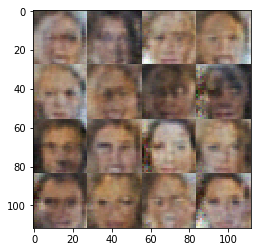

Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.9483
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 2.4980
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 2.2814
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 2.4174
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.7697


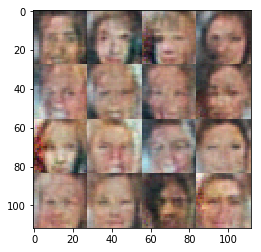

Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 2.2059
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 1.8454
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.4989
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 2.5875


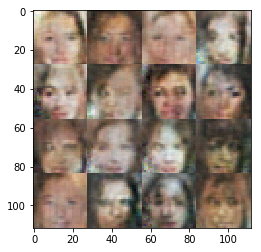

Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 2.1573
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.7801
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 2.2106


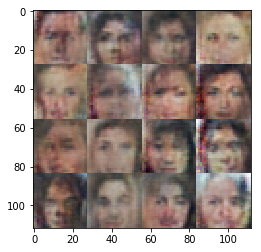

Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.5579
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.4682
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.5574


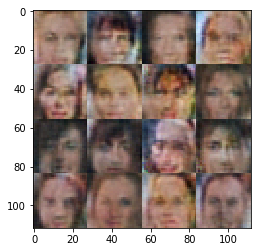

Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.3799
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.0777


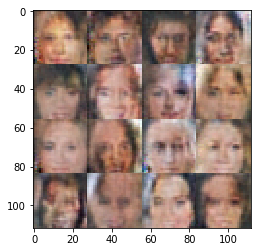

Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 2.0480
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.6509
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 2.2425


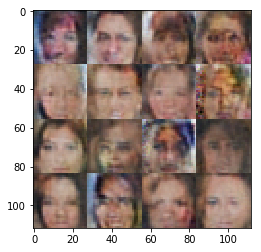

Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 2.2853
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.6475
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 2.0594
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.5394


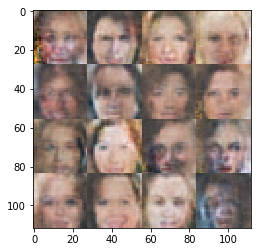

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.7567
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.3891
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 2.1324


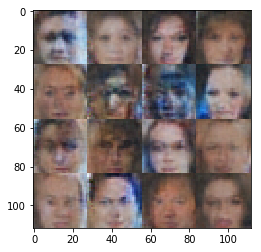

Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.8243
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.2368
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 2.4164
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0681


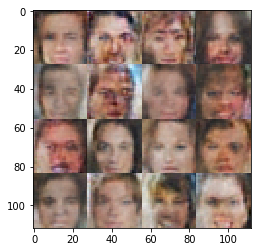

Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.6477
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.3024
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 2.0104
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.6107


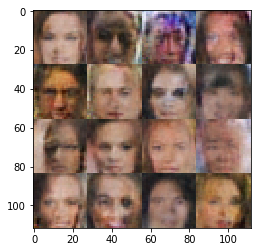

Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.5487
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.7968
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.8019
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.0099


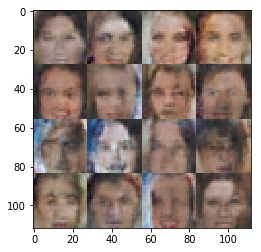

Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.6890
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.9876


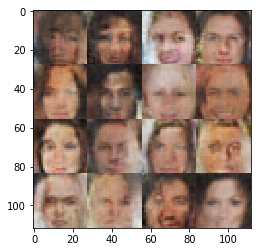

Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.5240
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.6147


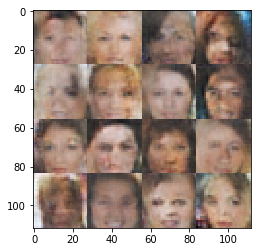

Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.5521
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.5616


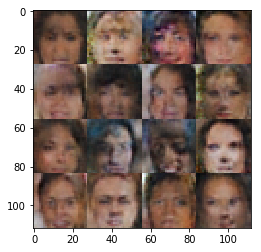

Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.4100
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.8994
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.2476


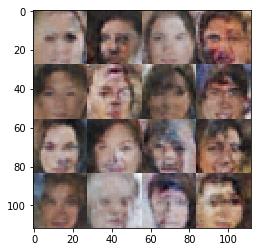

Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.5798
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.4643
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.0391


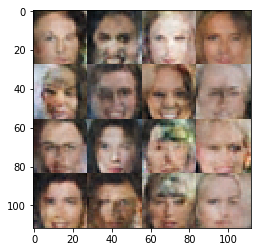

Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.5132
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.4168


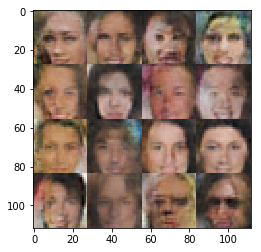

Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.7818
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.5685


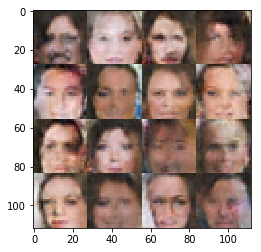

Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.5779
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.9284


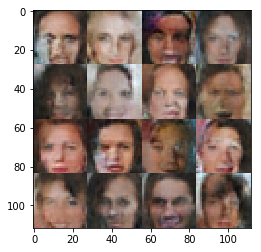

Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.6185


In [90]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.